In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers,mixed_precision
tf.__version__
mixed_precision.set_global_policy('mixed_float16')


2025-06-08 17:36:32.527998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749404192.717365      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749404192.774384      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # progress bar

# Load attributes
attr_df = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")
attr_df.rename(columns={'Unnamed: 0': 'image_id'}, inplace=True)

# Optional: use only one attribute (e.g., Smiling)
attr_df['Smiling'] = attr_df['Smiling'].apply(lambda x: 1 if x == 1 else 0)

# Load first N images
image_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
image_size = (64, 64)
n_images = 10000

X, y = [], []

for idx, row in tqdm(attr_df.iterrows(), total=n_images):
    if idx >= n_images:
        break
    img_path = os.path.join(image_dir, row['image_id'])
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img) / 255.0
    X.append(img_array)
    y.append(row['Smiling'])

X = np.array(X)
y = np.array(y)


100%|██████████| 10000/10000 [00:46<00:00, 214.83it/s]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
X_train.shape, y_train.shape

((8000, 64, 64, 3), (8000,))

In [5]:
buffer_size = 60000
batch_size = 32
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

I0000 00:00:1749404256.033200      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
# import tensorflow as tf
# from tensorflow.keras import layers

# def build_generator():
#     network = tf.keras.Sequential()

#     # Dense layer to expand input noise into 4x4x512
#     network.add(layers.Dense(units=4*4*512, use_bias=False, input_shape=(100,)))
#     network.add(layers.BatchNormalization())
#     network.add(layers.LeakyReLU())

#     network.add(layers.Reshape((4, 4, 512)))  # Shape: 4x4x512

#     # Upsample to 8x8x256
#     network.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     network.add(layers.BatchNormalization())
#     network.add(layers.LeakyReLU())

#     # Upsample to 16x16x128
#     network.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     network.add(layers.BatchNormalization())
#     network.add(layers.LeakyReLU())

#     # Upsample to 32x32x64
#     network.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     network.add(layers.BatchNormalization())
#     network.add(layers.LeakyReLU())

#     # Upsample to 64x64x32
#     network.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
#     network.add(layers.BatchNormalization())
#     network.add(layers.LeakyReLU())

#     # Final output layer: 64x64x3
#     network.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))

#     network.summary()
#     return network


In [7]:
import tensorflow as tf
from tensorflow.keras import layers

def resnet_generator_block(x, filters):
    """A basic residual block with upsampling."""
    shortcut = layers.UpSampling2D()(x)
    shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)

    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_generator():
    noise = tf.keras.Input(shape=(100,), dtype=tf.float32)

    x = layers.Dense(4*4*512, use_bias=False, dtype='float32')(noise)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4, 4, 512))(x)

    x = resnet_generator_block(x, 256)  # 8x8
    x = resnet_generator_block(x, 128)  # 16x16
    x = resnet_generator_block(x, 64)   # 32x32
    x = resnet_generator_block(x, 32)   # 64x64

    # Final output layer (float16)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='tanh', dtype='float16')(x)

    # Cast to float32 before output to prevent dtype mismatch in training
    x = tf.keras.layers.Lambda(lambda y: tf.cast(y, tf.float32))(x)

    model = tf.keras.Model(inputs=noise, outputs=x, name="ResNet_Generator_64x64")
    return model



In [8]:
# generator = build_generator()

In [9]:
generator = build_resnet_generator()

In [10]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.00761253,  1.5558976 ,  0.05669872, -0.22533676,  0.3221828 ,
        -1.1924845 , -1.6133066 , -0.35700566,  0.21660233, -0.3855419 ,
        -0.4394075 ,  0.62900007, -0.4500189 ,  0.41653538, -0.7160257 ,
        -1.1955792 , -0.45906356,  0.30332747, -1.215533  , -0.47569415,
        -1.8304847 ,  0.47170293, -0.6150924 ,  0.35557863,  0.01741086,
        -0.31439155, -0.37597352,  0.378807  ,  0.50571024,  0.12086084,
        -1.3000442 , -1.8813255 , -0.81358254, -0.17941773,  0.6027243 ,
         0.37194738,  0.08312378, -0.13862008,  1.2198973 ,  0.21102947,
        -0.09083768, -0.40415883,  0.48386633,  1.8372993 , -1.018425  ,
         0.8997626 ,  1.3590287 , -1.0440844 , -1.5948688 , -0.00647485,
        -1.5435736 ,  0.8009686 , -0.43521023,  0.7246697 , -0.8210615 ,
         0.39085263, -0.65052986,  1.1157547 , -1.1353374 , -0.8125846 ,
        -0.17534484,  0.74953073, -1.0119069 ,  0.32209763,  0.67396635,
 

I0000 00:00:1749404258.845889      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


(-0.5, 63.5, 63.5, -0.5)

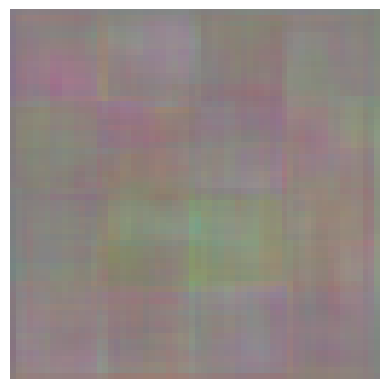

In [11]:
generated_image = generator(noise, training = False)
plt.imshow((generated_image[0] + 1) / 2.0)  # Rescale from [-1, 1] to [0, 1]
plt.axis("off")


In [12]:
# def build_discriminator():
#     network = tf.keras.Sequential()

#     # Input: 64x64x3 → 32x32x64
#     network.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
#     network.add(layers.LeakyReLU())
#     network.add(layers.Dropout(0.3))

#     # 32x32x64 → 16x16x128
#     network.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
#     network.add(layers.LeakyReLU())
#     network.add(layers.Dropout(0.3))

#     # 16x16x128 → 8x8x256
#     network.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
#     network.add(layers.LeakyReLU())
#     network.add(layers.Dropout(0.3))

#     # 8x8x256 → 4x4x512
#     network.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
#     network.add(layers.LeakyReLU())
#     network.add(layers.Dropout(0.3))

#     # Flatten and output a single score (real or fake)
#     network.add(layers.Flatten())
#     network.add(layers.Dense(1))

#     network.summary()
#     return network

In [13]:
def resnet_discriminator_block(x, filters, downsample=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    res = x

    # First conv layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)
    x = layers.LeakyReLU(0.2)(x)

    # Second conv layer
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', kernel_initializer=initializer)(x)

    # Downsample both paths
    if downsample:
        x = layers.AveragePooling2D(pool_size=(2, 2))(x)
        res = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same', kernel_initializer=initializer)(res)
        res = layers.AveragePooling2D(pool_size=(2, 2))(res)

    # Add skip connection
    x = layers.add([x, res])
    x = layers.LeakyReLU(0.2)(x)
    return x


In [14]:
def build_resnet_discriminator():
    input_img = tf.keras.Input(shape=(64, 64, 3))

    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(input_img)
    x = layers.LeakyReLU(0.2)(x)

    # ResNet blocks with downsampling
    x = resnet_discriminator_block(x, 128)   # 32x32
    x = resnet_discriminator_block(x, 256)   # 16x16
    x = resnet_discriminator_block(x, 512)   # 8x8
    x = resnet_discriminator_block(x, 512)   # 4x4

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1,dtype='float32')(x)  # Single scalar output (critic score)

    model = tf.keras.Model(inputs=input_img, outputs=x, name="ResNet_Discriminator")
    model.summary()
    return model


In [15]:
# discriminator = build_discriminator()

In [16]:
discriminator = build_resnet_discriminator()

Model: "ResNet_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 64, 64, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ cast_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 64)     │              0 │ conv2d_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 64, 64, 128)    │              0 │ conv2d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 64, 64, 128)    │          8,320 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d         │ (None, 32, 32, 128)    │              0 │ conv2d_15[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_1       │ (None, 32, 32, 128)    │              0 │ conv2d_16[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 32, 128)    │              0 │ average_pooling2d[0][… │
│                           │                        │                │ average_pooling2d_1[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 32, 32, 128)    │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ conv2d_17[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 32, 32, 256)    │         33,024 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling2d_2       │ (None, 16, 16, 256)    │              0 │ conv2d_18[0][0]        │
│ (AveragePooling2D)        │                        │                │                        │
├──────────────────────

 Total params: 9,804,161 (37.40 MB)

 Trainable params: 9,804,161 (37.40 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00012202]], dtype=float32)>

In [18]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output) # need to minimize the difference by generator
  return g_loss

In [19]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0] # form the gradient of the image
  gradient_norm = tf.norm(gradient) # L2 normalization
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9) # in the paper these are default values, basically the beta param used to reduce the learning rate exponencially
generator_optimizer = mixed_precision.LossScaleOptimizer(generator_optimizer)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = mixed_precision.LossScaleOptimizer(discriminator_optimizer)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

In [23]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [24]:
# def training_step(images):
#   noise = tf.random.normal([batch_size, noise_dim])
#   discriminator_extra_steps = 3 #You update the discriminator 3 times per generator update.Helps it stay ahead of the generator.
#   for i in range(discriminator_extra_steps):
#     with tf.GradientTape() as d_tape:
#       generated_images = generator(noise, training = True)
#       real_output = discriminator(images, training = True)
#       fake_output = discriminator(generated_images, training = True)
#       epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0) #This samples random coefficients t∼U[0,1] for interpolation.Shape is broadcasted for image tensors.
#       gp = gradient_penalty(images, generated_images, epsilon)

#       d_loss = loss_discriminator(real_output, fake_output, gp) # critic loss
#     discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
#     discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

#   with tf.GradientTape() as g_tape:
#     generated_images = generator(noise, training = True)
#     fake_output = discriminator(generated_images, training = True) #Generates new fake images.Gets their critic score from the discriminator.
#     g_loss = loss_generator(fake_output) #Generator wants to maximize the critic's score:E[D( x~ )], i.e., make fake look real.But because you use gradient descent, you minimize −E[D( x~ )]
#   generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
#   generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables)) #Backpropagate and update the generator’s weights.

def training_step(images):
    # Generate latent vectors (noise)
    noise = tf.random.normal([batch_size, noise_dim])

    discriminator_extra_steps = 3  # Multiple updates for critic

    for i in range(discriminator_extra_steps):
        with tf.GradientTape() as d_tape:
            # Generate fake images
            generated_images = generator(noise, training=True)

            # Get critic scores for real and fake images
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)

            # Interpolation for gradient penalty
            epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
            gp = gradient_penalty(images, generated_images, epsilon)

            # WGAN-GP critic loss
            d_loss = loss_discriminator(real_output, fake_output, gp)

        # Apply discriminator (critic) gradients
        discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Train generator
    with tf.GradientTape() as g_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        g_loss = loss_generator(fake_output)

    generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))


In [25]:
def create_and_save_images(model, epoch, test_input):
    preds = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i + 1)

        # Rescale from [-1, 1] to [0, 1]
        img = (preds[i] + 1) / 2.0

        # Display RGB image
        plt.imshow(img)
        plt.axis('off')

    plt.savefig('img_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)  # Optional: Close figure to save memory


In [26]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start_time = time.time()

        for img_batch in dataset:
            if len(img_batch) == batch_size:
                training_step(img_batch)

        # Save generated images for this epoch
        create_and_save_images(generator, epoch + 1, seed)

        # Save model checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time taken to process epoch {epoch + 1} was {time.time() - start_time:.2f} seconds')

    # Final image and model saving after training ends
    create_and_save_images(generator, epochs, seed)
    generator.save('generator.h5')


In [27]:
train(X_train, epochs)

Time taken to process epoch 1 was 533.88 seconds
Time taken to process epoch 2 was 520.92 seconds
Time taken to process epoch 3 was 520.70 seconds
Time taken to process epoch 4 was 519.39 seconds
Time taken to process epoch 5 was 519.73 seconds
Time taken to process epoch 6 was 511.44 seconds
Time taken to process epoch 7 was 511.07 seconds
Time taken to process epoch 8 was 508.91 seconds
Time taken to process epoch 9 was 509.85 seconds
Time taken to process epoch 10 was 510.69 seconds
Time taken to process epoch 11 was 511.92 seconds
Time taken to process epoch 12 was 510.58 seconds
Time taken to process epoch 13 was 510.92 seconds
Time taken to process epoch 14 was 510.93 seconds
Time taken to process epoch 15 was 509.02 seconds
Time taken to process epoch 16 was 514.28 seconds
Time taken to process epoch 17 was 512.80 seconds
Time taken to process epoch 18 was 509.51 seconds
Time taken to process epoch 19 was 510.08 seconds
Time taken to process epoch 20 was 511.59 seconds
Time take

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))